[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmed-fouad-lagha/Intro-Data-Security/blob/main/module_02_input_manipulation/Lab_2a_Evasion_Attacks.ipynb)

# **Lab 2a: Evasion Attacks (Adversarial Examples)**

**Course:** Introduction to Data Security Pr.  
**Module 2:** Input Data Manipulation  
**Estimated Time:** 90–120 minutes

---

## **Learning Objectives**

By the end of this lab, you will be able to:
- Generate adversarial examples using FGSM and PGD
- Measure model robustness under $\ell_\infty$ perturbations
- Visualize perturbations and their impact on predictions
- Compare clean vs. adversarial accuracy
- Discuss the robustness–accuracy tradeoff

---

## **Table of Contents**
1. Setup & Imports  
2. Load Model & Dataset  
3. Baseline Evaluation  
4. FGSM Attack  
5. PGD Attack  
6. Robustness Evaluation  
7. Visual Analysis  
8. Exercises

---

## **1. Setup & Imports**

In [1]:
# If needed, install dependencies
# !pip install torch torchvision matplotlib numpy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## **2. Load Model & Dataset**

We will reuse the MNIST model trained in Lab 1a. If you don’t have the checkpoint, train a quick baseline model in this notebook.

In [ ]:
# Load MNIST test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Optional train set for fallback training
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define a simple CNN (use same as Lab 1a)
class StandardCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = StandardCNN().to(device)

# Try loading weights from Lab 1a
model_path = '../module_01_foundations/standard_mnist_dnn.pth'
loaded = False
try:
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    loaded = True
    print("Loaded model from Lab 1a")
except Exception as e:
    print("Model checkpoint not found. Training a quick baseline below.")

model.eval()

# Normalized clamp bounds for MNIST
mnist_mean = 0.1307
mnist_std = 0.3081
min_val = (0.0 - mnist_mean) / mnist_std
max_val = (1.0 - mnist_mean) / mnist_std
print(f"Normalized clamp range: [{min_val:.2f}, {max_val:.2f}]")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 244kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]

Model checkpoint not found. Training a quick baseline below.
Normalized clamp range: [-0.42, 2.82]


In [3]:
# Optional fallback training if checkpoint is missing
if not loaded:
    print("Training a quick baseline model (2 epochs, limited batches)...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    max_batches = 100
    for epoch in range(2):
        running_loss = 0.0
        for i, (x, y) in enumerate(train_loader):
            if i >= max_batches:
                break
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/2: Loss={running_loss / max_batches:.4f}")
    model.eval()
    print("Baseline training complete.")

Training a quick baseline model (2 epochs, limited batches)...
Epoch 1/2: Loss=0.4897
Epoch 2/2: Loss=0.1196
Baseline training complete.


## **3. Baseline Evaluation**

In [4]:
def evaluate(model, loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

clean_acc = evaluate(model, test_loader)
print(f"Clean accuracy: {clean_acc * 100:.2f}%")

Clean accuracy: 97.35%


## **4. FGSM Attack**

The Fast Gradient Sign Method (FGSM) crafts adversarial examples by taking a single step in the direction of the input gradient.

In [5]:
def fgsm_attack(model, x, y, epsilon=0.3):
    x = x.clone().detach().to(device)
    y = y.to(device)
    x.requires_grad = True

    logits = model(x)
    loss = nn.CrossEntropyLoss()(logits, y)
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * x.grad.sign()
    x_adv = x + perturbation
    x_adv = torch.clamp(x_adv, min_val, max_val)
    return x_adv.detach()

## **5. PGD Attack**

Projected Gradient Descent (PGD) iterates FGSM steps and projects back into the $\epsilon$-ball.

In [6]:
def pgd_attack(model, x, y, epsilon=0.3, alpha=0.01, steps=40):
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_adv = x + 0.001 * torch.randn_like(x)

    for _ in range(steps):
        x_adv.requires_grad = True
        logits = model(x_adv)
        loss = nn.CrossEntropyLoss()(logits, y)
        model.zero_grad()
        loss.backward()
        grad = x_adv.grad.sign()

        x_adv = x_adv + alpha * grad
        perturbation = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + perturbation, min_val, max_val).detach()
    return x_adv

## **6. Robustness Evaluation**

In [7]:
def adversarial_accuracy(model, loader, attack_fn, **kwargs):
    correct, total = 0, 0
    model.eval()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack_fn(model, x, y, **kwargs)
        logits = model(x_adv)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

fgsm_acc = adversarial_accuracy(model, test_loader, fgsm_attack, epsilon=0.3)
pgd_acc = adversarial_accuracy(model, test_loader, pgd_attack, epsilon=0.3, alpha=0.01, steps=20)

print(f"FGSM accuracy (eps=0.3): {fgsm_acc * 100:.2f}%")
print(f"PGD accuracy (eps=0.3):  {pgd_acc * 100:.2f}%")

FGSM accuracy (eps=0.3): 86.00%
PGD accuracy (eps=0.3):  90.66%


## **7. Visual Analysis**

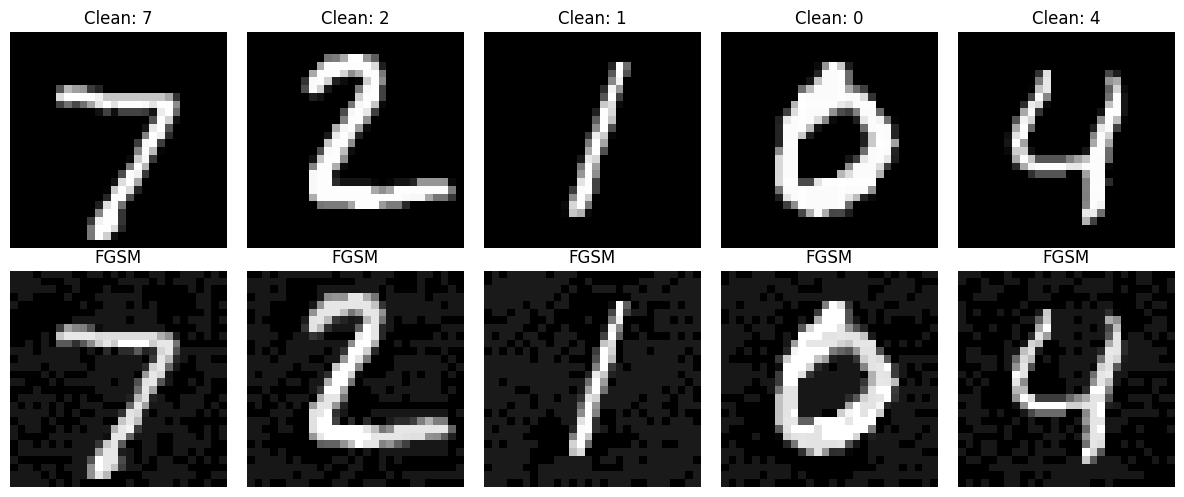

In [8]:
# Visualize adversarial examples
x, y = next(iter(test_loader))

x_adv_fgsm = fgsm_attack(model, x[:5], y[:5], epsilon=0.3)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow((x[i].squeeze() * 0.3081 + 0.1307).cpu(), cmap='gray')
    axes[0, i].set_title(f"Clean: {y[i].item()}")
    axes[0, i].axis('off')

    axes[1, i].imshow((x_adv_fgsm[i].squeeze() * 0.3081 + 0.1307).cpu(), cmap='gray')
    axes[1, i].set_title("FGSM")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## **8. Exercises**

1. Run FGSM with $\epsilon \in \{0.05, 0.1, 0.2, 0.3\}$ and plot accuracy vs. $\epsilon$.  
2. Increase PGD steps to 50 and analyze how robustness changes.  
3. Compare $\ell_\infty$ vs. $\ell_2$ constraints (bonus).  
4. Discuss why PGD is generally stronger than FGSM.